**RUN THIS CELL IF RUNNING IN GOOGLE COLAB**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/capstone')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
from ProjectModules.PlottingModule import plot_count_plot, distribution_plot, create_wordclouds
from ProjectModules.LanguageDetectionModule import lang_detect
from ProjectModules.TextProcessingAndCleaningModule import make_tokens, fix_unicode_characters

installing wordcloud python package...
Done!
installing langdetect python package...
Done!
installing ftfy python package...
Done!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# RUN THIS DATAPATH IF RUNNING IN GOOGLE COLAB, GIVE THE CORRECT PATH TO THE DATA
DATAPATH = '/content/drive/MyDrive/capstone/DataFiles/'
# *************************** --------------------------************************************
# DATAPATH = 'DataFiles/'

df = pd.read_excel(DATAPATH+"input_data.xlsx")
df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
print("Size of the dataset: ",df.shape[0]," records")

Size of the dataset:  8500  records


In [ ]:
print(df.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB
None 



**Finding missing values:**<br>
We have 8 missing values in short description column and 1 in description column

In [ ]:
print(df.isnull().sum(),'\n')

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64 



**Lets see them:**

In [ ]:
df[(df['Short description'].isnull()) | (df['Description'].isnull())]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


**Filling nan values with a blank string:**<br>
Then we'll fill missing "short description" values with corresponding "description" values and missing "description" values with corresponding "short description" values

In [ ]:
df['Short description'].fillna(value="",inplace=True)
df['Description'].fillna(value = "",inplace=True)

In [ ]:
def fill_missing_short_desc(row):
  if(row["Short description"]==''):
    return row["Description"]
  else:
    return row["Short description"]


def fill_missing_desc(row):
  if(row["Description"]==''):
    return row["Short description"]
  else:
    return row["Description"]

df["Short description"] = df.apply(fill_missing_short_desc,axis=1)
df["Description"] = df.apply(fill_missing_desc,axis=1)

**No missing values now**

In [ ]:
df[(df['Short description']=='') | (df['Description']=='')]

,Short description,Description,Caller,Assignment group


**Now we can drop caller column since we wont need it for modelling**

In [ ]:
df.drop(['Caller'],inplace=True,axis=1)
df.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


**Removing duplicate rows:**

In [ ]:
df_dup = df[df.duplicated(keep="first")]
print("Total duplicate values: ",df_dup.shape[0])
display(df_dup.head(10))

Total duplicate values:  591


,Short description,Description,Assignment group
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,GRP_0
81,erp SID_34 account locked,erp SID_34 account locked,GRP_0
123,unable to display expense report,unable to display expense report,GRP_0
157,ess password reset,ess password reset,GRP_0
229,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,GRP_0
235,erp SID_34 account unlock and password reset,erp SID_34 account unlock and password reset,GRP_0
242,windows password reset,windows password reset,GRP_0
274,windows account locked,windows account locked,GRP_0
301,windows password reset,windows password reset,GRP_0
312,erp SID_34 account unlock,erp SID_34 account unlock,GRP_0


In [ ]:
df = df[~df.duplicated(keep="first")]
print("Size after removing duplicates: ",df.shape)
print("\nNo more duplicate values: ")
display(df[df.duplicated(keep="first")])

Size after removing duplicates:  (7909, 3)

No more duplicate values: 


,Short description,Description,Assignment group


**Lets analyse target variable:**<br>
We have skewed target distribution<br><br>
We'll import all the necessary functions from PlottingModule. You can find PlottingModule.py in ProjectModules folder. **This module contains all the functions that we have used in our visualizations**

In [ ]:
print(plot_count_plot.__doc__)


    Plots a count plot. Width and height fixed at 20px and 7px respectively.
    
    values: pass count(integers) as an array/list/series
    labels: pass labels(string) corresponding to the count as an array/list
    xlabel: label for x-axis (string)
    ylabel: label for y-axis (string)
    title: title of the plot (string)
    


We have total 74 labels in the target. Following labels are there:

GRP_0    0.433557
GRP_8    0.081553
Name: Assignment group, dtype: float64 



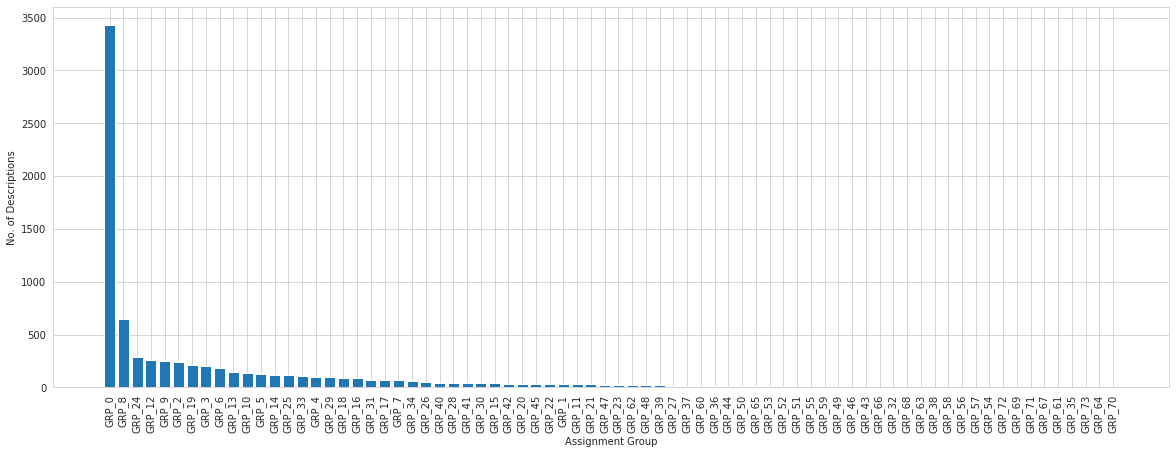

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().to_dict().values()
labels = df["Assignment group"].value_counts().to_dict().keys()
print("We have total 74 labels in the target. Following labels are there:\n")
print(df["Assignment group"].value_counts(normalize=True).head(2),"\n")
plot_count_plot(values,labels,xlabel,ylabel)

**Assignment Group 0 has maximum number of tickets, followed by Assignment Group 8**

Except GRP_0, other classes are distributed as following:



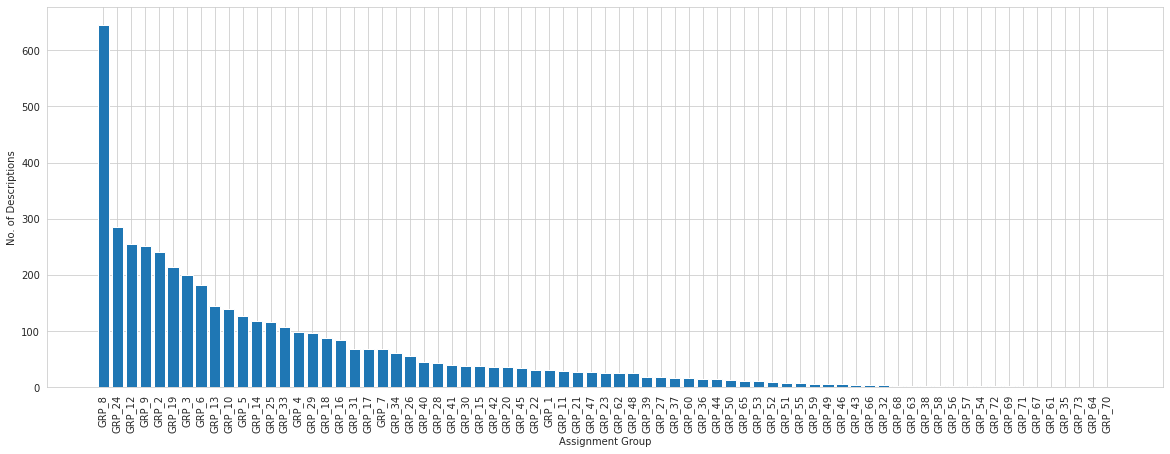

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts()[1:].to_dict().values()
labels = df["Assignment group"].value_counts()[1:].to_dict().keys()
print("Except GRP_0, other classes are distributed as following:\n")
plot_count_plot(values,labels,xlabel,ylabel)

Top 20 labels

GRP_0     3429
GRP_8      645
GRP_24     285
GRP_12     256
GRP_9      252
GRP_2      241
GRP_19     214
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4       99
GRP_29      97
GRP_18      88
GRP_16      85
GRP_31      69
Name: Assignment group, dtype: int64 



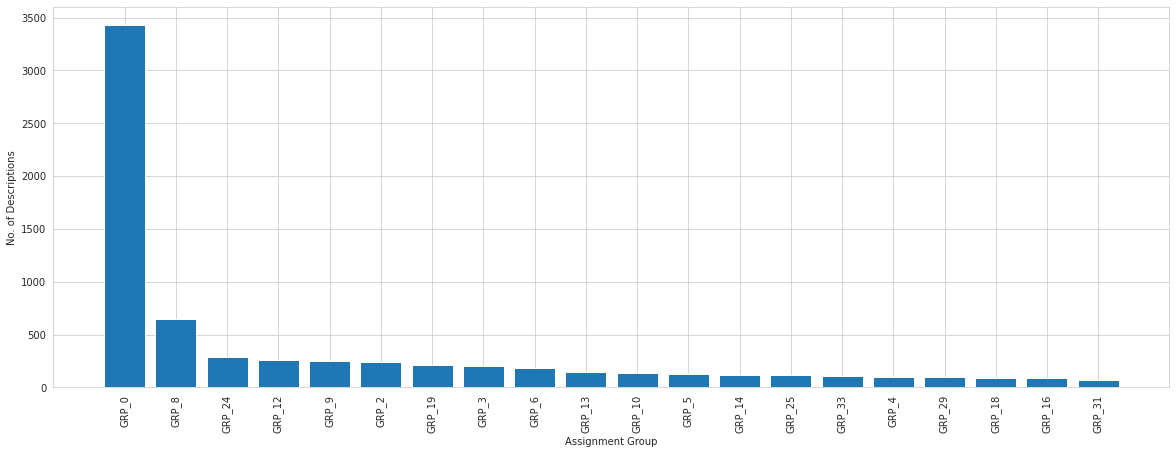

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().head(20).to_dict().values()
labels = df["Assignment group"].value_counts().head(20).to_dict().keys()
print("Top 20 labels\n")
print(df["Assignment group"].value_counts().head(20),"\n")
plot_count_plot(values,labels,xlabel,ylabel)

Least 20 labels

GRP_46    6
GRP_43    5
GRP_66    4
GRP_32    4
GRP_68    3
GRP_63    3
GRP_38    3
GRP_58    3
GRP_56    3
GRP_57    2
GRP_54    2
GRP_72    2
GRP_69    2
GRP_71    2
GRP_67    1
GRP_61    1
GRP_35    1
GRP_73    1
GRP_64    1
GRP_70    1
Name: Assignment group, dtype: int64 



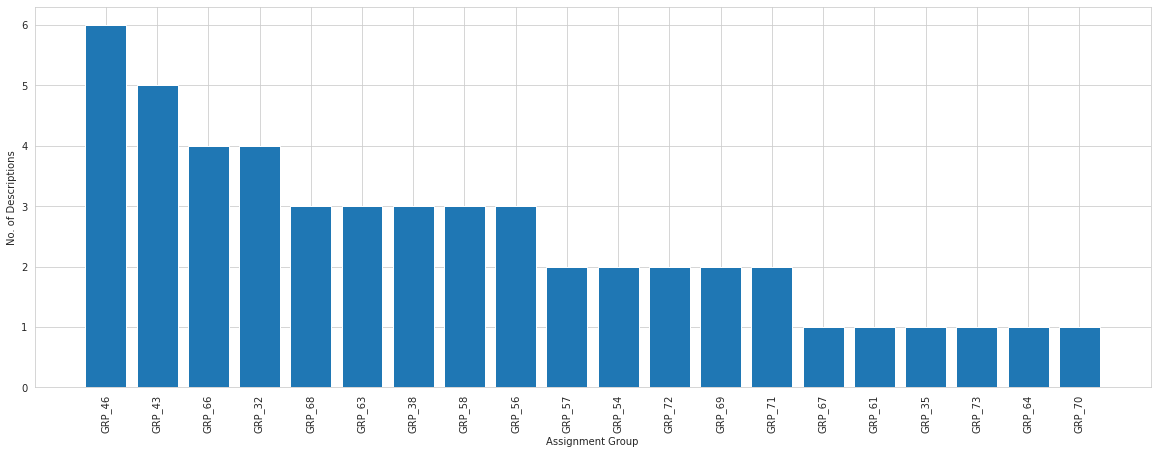

In [ ]:
xlabel = "Assignment Group"
ylabel = "No. of Descriptions"
values = df["Assignment group"].value_counts().tail(20).to_dict().values()
labels = df["Assignment group"].value_counts().tail(20).to_dict().keys()
print("Least 20 labels\n")
print(df["Assignment group"].value_counts().tail(20),"\n")
plot_count_plot(values,labels,xlabel,ylabel)

**Note that in group 61, 67, 64, 73, 70 and 35 we only have 1 ticket**
<br><br>**Detecting if text is multilingual:**<br>
We'll import the lang_detect function from LanguageDetectionModule. You can find LanguageDetectionModule.py in ProjectModules folder

In [ ]:
print(lang_detect.__doc__)


    Detects language of the text. 
    If a language is detected, returns the ISO 639-1 language code, else "unknown"
    
    text: text to detect language (string)
    


In [ ]:
df['Language'] = df["Description"].apply(lang_detect)

Count of descriptions per language



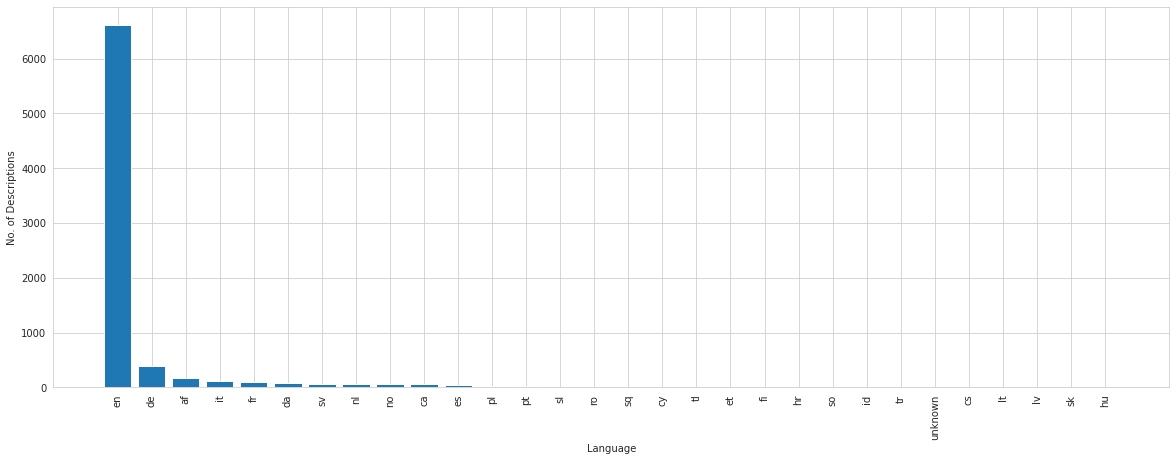

In [ ]:
xlabel = "Language"
ylabel = "No. of Descriptions"
values = df["Language"].value_counts().to_dict().values()
labels = df["Language"].value_counts().to_dict().keys()
print("Count of descriptions per language\n")
plot_count_plot(values,labels,xlabel,ylabel)

**Most number of tickets are in English**

Top 5 most common languages



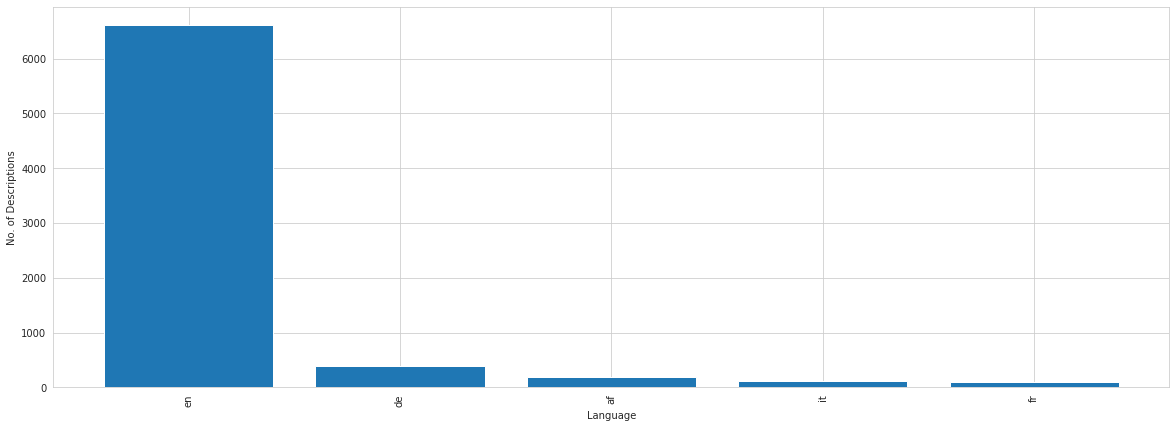

In [ ]:
xlabel = "Language"
ylabel = "No. of Descriptions"
values = df["Language"].value_counts().head(5).to_dict().values()
labels = df["Language"].value_counts().head(5).to_dict().keys()
print("Top 5 most common languages\n")
plot_count_plot(values,labels,xlabel,ylabel)

**Since we have multilingual data, therefore we can see that we have a lot of unicode characters:**<br>Displaying some of them

In [ ]:
c=1
for ind,txt in enumerate(df['Description']):
  regex = r"[^#\\\//+a-zA-Z0-9!\n\r@\s,_():.@_%&-\?\]\[\"\,\'\|{}]"
  unicode_char = re.findall(regex,txt.strip())
  patt = [x[0] for x in unicode_char]
  if(len(patt)>0):
    if(c>=11):
      break;
    print("row:",ind)
    print(patt)
    c=c+1

row: 82
['$', '$', '$', '$', '$', '$', '$', '$', '$', '$', '$', '$', '$', '$', '$', '$']
row: 97
['â', '€', '¦']
row: 114
['â', '€', '¦']
row: 121
['Ã', '³', 'Ã', '³']
row: 158
['â', '˜', 'º', 'Å', '„', 'Ä', '…', 'Å', '„', 'Ã', '³', 'Å', '‚', 'Ä', '…', 'Å', '„', 'Å', '‚', 'Å', '‚', 'Å', '‚']
row: 160
['å', '°', '†', 'æ', '’', '¤', 'å', '›', 'ž', 'é', '‚', '®', 'ä', '»', '¶', 'ã', '€', '‚', 'æ', 'œ', '¬', 'è', '®', '¯', 'æ', '\x81', '¯', 'ä', '»', '…', 'ä', '¾', '›', 'æ', 'Œ', '‡', 'å', '®', 'š', 'ç', 'š', '„', 'æ', 'Ž', '¥', 'æ', '”', '¶', 'ä', 'º', 'º', 'ä', '½', '¿', 'ç', '”', '¨', 'ï', '¼', 'Œ', 'å', '…', '¶', 'ä', '¸', '\xad', 'å', '\x8f', '¯', 'è', 'ƒ', '½', 'å', 'Œ', '…', 'å', '\x90', '«', 'é', '€', '‚', 'ç', '”', '¨', 'æ', '³', '•', 'å', '¾', '‹', 'é', '¡', '¹', 'ä', '¸', '‹', 'ç', '‰', '¹', 'è', '®', '¸', 'ç', 'š', '„', 'ã', '€', '\x81', 'ä', '¿', '\x9d', 'å', '¯', '†', 'ç', 'š', '„', 'å', '’', 'Œ', 'ç', '¦', '\x81', 'æ', '\xad', '¢', 'æ', 'Š', '«', 'é', 'œ', '²', 'ç', 'š', '„'

**We will fix unicode characters using ftfy python package's fit_text function. We have already set it up in TextProcessingAndCleaningModule. We have already imported fix_unicode_characters() function from this module**

In [ ]:
print(fix_unicode_characters.__doc__)


    Fixes unicode characters using ftfy python package
    text: text to clean
    


In [ ]:
# fixing unicode characters
df["Description"] = df["Description"].apply(fix_unicode_characters)
df["Short description"] = df["Short description"].apply(fix_unicode_characters)

**Text cleaning and pre-processing:**<br>
lets first see the raw descriptions and shorts description before cleaning it - printing first 10 records for both<br><br> 
**Short Description:-**

In [ ]:
for i,txt in enumerate(df['Short description']):
  if(i>9):
    break;
  print(str(i+1)+")\n",txt,"\n#######################################\n")

1)
 login issue 
#######################################

2)
 outlook 
#######################################

3)
 cant log in to vpn 
#######################################

4)
 unable to access hr_tool page 
#######################################

5)
 skype error  
#######################################

6)
 unable to log in to engineering tool and skype 
#######################################

7)
 event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/  
#######################################

8)
 ticket_no1550391- employment status - new non-employee [enter user's name] 
#######################################

9)
 unable to disable add ins on outlook 
#######################################

10)
 ticket update on inplant_874773 
#######################################



**Description:-**

In [ ]:
for i,txt in enumerate(df['Description']):
  if(i>9):
    break;
  print(str(i+1)+")\n",txt,"\n#######################################\n")

1)
 -verified user details.(employee# & manager name)
-checked the user name in ad and reset the password.
-advised the user to login and check.
-caller confirmed that he was able to login.
-issue resolved. 
#######################################

2)
 

received from: hmjdrvpb.komuaywn@gmail.com

hello team,

my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?

kind  
#######################################

3)
 

received from: eylqgodm.ybqkwiam@gmail.com

hi

i cannot log on to vpn

best  
#######################################

4)
 unable to access hr_tool page 
#######################################

5)
 skype error  
#######################################

6)
 unable to log in to engineering tool and skype 
#######################################

7)
 event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/sr3psa1d_7/sr3psa1d.data7,perpsr3psa1d,4524 is 98 
#####

**Lets look at some numerical other specific patterns in the dataset:**<br>We have hyperlinks and other weblinks


In [ ]:
c=1
for ind,txt in enumerate(df['Description']):
  regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
  url = re.findall(regex,txt)
  patt = [x[0] for x in url]
  if(len(patt)>0):
    if(c>=11):
      break;
    c=c+1
    print("row:",ind)
    print(patt)      

row: 158
['www.company.com']
row: 727
['www.company.com']
row: 1391
['www.company.com', 'www.company.com']
row: 1617
['www.company.com']
row: 1729
['www.company.com']
row: 1824
['www.company.com']
row: 2341
['www.company.com']
row: 2376
['www.company.com']
row: 2510
['www.company.com']
row: 2720
['www.company.com', 'www.company.com/engineering_tool/en/home.html']


We have ip addresses

In [ ]:
c=1
for ind,txt in enumerate(df['Description']):
  regex = r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}[^0-9]"
  ipaddress = re.findall(regex,txt)
  if(len(ipaddress)>0):
    if(c>=11):
      break;
    c=c+1
    print("row:",ind)
    print(ipaddress)

row: 323
['10.170.245.10\n']
row: 630
['29.21.92.849]', '29.21.92.849:']
row: 653
['83.69.48.194 ']
row: 751
['83.69.48.194 ']
row: 755
['83.69.48.194 ']
row: 764
['83.69.48.194 ']
row: 767
['83.69.48.194 ']
row: 770
['83.69.48.194 ']
row: 771
['83.69.48.194 ']
row: 772
['83.69.48.194 ']


We have different date and time patterns


In [ ]:
c=1
for ind,txt in enumerate(df['Description']):
  regex = r'(\d+/\d+/\d+ | \d+-\d+-\d+ | \d+:\d+:\d+)'  
  datentime = re.findall(regex,txt)
  if(len(datentime)>0):
    if(c>=21):
      break;
    c=c+1
    print("row:",ind)
    print(datentime)

row: 47
['10/31/2016 ']
row: 50
['10/31/2016 ']
row: 58
['10/31/2016 ']
row: 59
['10/31/2016 ']
row: 66
['10/31/2016 ']
row: 67
['10/31/2016 ']
row: 68
['10/31/2016 ']
row: 69
['10/31/2016 ']
row: 74
['10/30/2016 ']
row: 75
['10/30/2016 ']
row: 76
['10/30/2016 ']
row: 78
['10/30/2016 ']
row: 79
['10/30/2016 ']
row: 81
['10/30/2016 ']
row: 82
[' 08:06:34', ' 2015-07-24 ', ' 2015-07-24 ', ' 2015-07-24 ', ' 2016-02-18 ', ' 2014-07-16 ']
row: 83
['10/30/2016 ']
row: 84
['10/30/2016 ']
row: 85
['10/30/2016 ']
row: 87
['10/29/2016 ']
row: 88
['10/29/2016 ']


We have email ids

In [ ]:
c=1
for ind,txt in enumerate(df['Description']):
  regex = r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[(com|org|edu)]{2,4}"
  email = re.findall(regex,txt)
  if(len(email)>0):
    if(c>=11):
      break;
    c=c+1
    print("row:",ind)
    print(email)

row: 1
['hmjdrvpb.komuaywn@gmail.com']
row: 2
['eylqgodm.ybqkwiam@gmail.com']
row: 16
['xyz@company.com']
row: 21
['ugephfta.hrbqkvij@gmail.com']
row: 24
['dceoufyz.saufqkmd@gmail.com']
row: 32
['kxsceyzo.naokumlb@gmail.com']
row: 43
['yisohglr.uvteflgb@gmail.com']
row: 47
['monitoring_tool@company.com']
row: 50
['monitoring_tool@company.com']
row: 52
['cdbaoqts.wqbsodni@gmail.com', 'cdbaoqts.wqbsodni@gmail.com', 'cdbaoqts.wqbsodni@gmail.com']


We have other sentences that have alpha-numeric words:

In [ ]:
c=1
for ind,txt in enumerate(df['Description']):
  regex = r"(.*)[\d](.*)$"
  sent = re.findall(regex,txt)
  patt = [x[0] for x in sent]
  if(len(patt)>0):
    if(c>=21):
      break;
    c+=1
    print("row:",ind)
    print(patt)
    print("####################################")      

row: 6
['event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/sr3psa1d_7/sr3psa1d.data7,perpsr3psa1d,4524 is 9']
####################################
row: 7
['ticket_no155039']
####################################
row: 9
['ticket update on inplant_87477']
####################################
row: 15
['ticket update on inplant_87474']
####################################
row: 18
['erp SID_3']
####################################
row: 25
['erp SID_3']
####################################
row: 29
['unable to log in to erp SID_3']
####################################
row: 35
['ticket_no156467']
####################################
row: 36
['erp SID_3']
####################################
row: 40
['ticket update - inplant_87461']
####################################
row: 41
['tablet 735']
####################################
row: 47
['job Job_1424 failed in job_scheduler at: 10/31/2016 09:06:0']
####################################
row: 50

**We'll import the make_tokens function from TextProcessingAndCleaningModule:**<br>You can find TextProcessingAndCleaningModule.py in ProjectModules folder<br><br>**This module contains all our code for cleaning, lemmatizing and tokenizing. We just have to import the make_tokens function and pass the text we want to tokenize**<br>**We have used parts of speech tagging (pos) based lemmatizer. The whole code is explained in the TextProcessingAndCleaningModule.py file** 

In [ ]:
print(make_tokens.__doc__)


  This function will remove punctuations, lowercase the word, escape the html entities, remove email ids and 
  corresponding jargons, replaces hyperlinks and ip addresses with corresponding words, removes date and 
  time, replace contractions, remove special characters, remove stopwords, lemmatize and tokenize the text
  
  text: text to clean, lemmatize and tokenize (string)
  
  Returns cleaned, lemmatized and tokenized text
  


**Lets see some samples before and after cleaning - printing some samples from Short Description column**

In [ ]:
for i in df['Short description'][:10]:
  print("------------ORIGINAL TEXT------------ \n",i)
  print("------------CLEANED TOKENS:------------ \n",make_tokens(i),"\n\n##########################\n\n")

------------ORIGINAL TEXT------------ 
 login issue
------------CLEANED TOKENS:------------ 
 login issue 

##########################


------------ORIGINAL TEXT------------ 
 outlook
------------CLEANED TOKENS:------------ 
 outlook 

##########################


------------ORIGINAL TEXT------------ 
 cant log in to vpn
------------CLEANED TOKENS:------------ 
 cant log vpn 

##########################


------------ORIGINAL TEXT------------ 
 unable to access hr_tool page
------------CLEANED TOKENS:------------ 
 unable access hr tool page 

##########################


------------ORIGINAL TEXT------------ 
 skype error 
------------CLEANED TOKENS:------------ 
 skype error 

##########################


------------ORIGINAL TEXT------------ 
 unable to log in to engineering tool and skype
------------CLEANED TOKENS:------------ 
 unable log engineering tool skype 

##########################


------------ORIGINAL TEXT------------ 
 event: critical:HostName_221.company.com the va

**Printing some samples from Description column**

In [ ]:
for i in df['Description'][:10]:
  print("------------ORIGINAL TEXT------------ \n",i)
  print("------------CLEANED TOKENS:------------ \n",make_tokens(i),"\n\n##########################\n\n")

------------ORIGINAL TEXT------------ 
 -verified user details.(employee# & manager name)
-checked the user name in ad and reset the password.
-advised the user to login and check.
-caller confirmed that he was able to login.
-issue resolved.
------------CLEANED TOKENS:------------ 
 verify user detail employee manager name check user name ad reset password advise user login check caller confirm able login issue resolve 

##########################


------------ORIGINAL TEXT------------ 
 

received from: hmjdrvpb.komuaywn@gmail.com

hello team,

my meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?

kind 
------------CLEANED TOKENS:------------ 
 team meeting skype meeting etc appear outlook calendar somebody please advise correct kind 

##########################


------------ORIGINAL TEXT------------ 
 

received from: eylqgodm.ybqkwiam@gmail.com

hi

i cannot log on to vpn

best 
------------CLEANED TOKENS:-------

**Now that we have seen how it works, lets clean the whole dataset:**

In [ ]:
df["cleaned_short_desc"] = df["Short description"].apply(make_tokens)
df["cleaned_desc"] = df["Description"].apply(make_tokens)
df.head()

,Short description,Description,Assignment group,Language,cleaned_short_desc,cleaned_desc
0,login issue,-verified user details.(employee# & manager na...,GRP_0,en,login issue,verify user detail employee manager name check...
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,GRP_0,en,outlook,team meeting skype meeting etc appear outlook ...
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,GRP_0,en,cant log vpn,cannot log vpn best
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0,en,unable access hr tool page,unable access hr tool page
4,skype error,skype error,GRP_0,no,skype error,skype error


**Lets see if we have any missing values in cleaned and tokenized columns:**

In [ ]:
df["temp_csd"] = [x.split() for x in df["cleaned_short_desc"]]
df["temp_cd"] = [x.split() for x in df["cleaned_desc"]]

In [ ]:
print("Short description column")
tempdf = df[df["temp_csd"].map(len) <= 0]
print(tempdf.shape)
display(tempdf.head(20))
print("\n######################################\n")
print("Description column")
tempdf = df[df["temp_cd"].map(len) <= 0]
print(tempdf.shape)
display(tempdf.head(20))

Short description column
(48, 8)


,Short description,Description,Assignment group,Language,cleaned_short_desc,cleaned_desc,temp_csd,temp_cd
1081,用友软件问题,"打开已关闭的销售订单时,显示""不能在手动或分布事物方式下创建新的链接""",GRP_48,da,,,[],[]
1178,电话机没有声音,电话机没有声音,GRP_30,da,,,[],[]
1452,考勤系统进不去请处理谢谢!,考勤系统进不去请处理谢谢!,GRP_30,it,,,[],[]
1568,电脑无法打开网页。,"张工您好!\n我的电脑连接公司网络无法使用(但163等正常),信息如下:(crm无法登陆,v...",GRP_31,da,,163 crm vpn ethic,[],"[163, crm, vpn, ethic]"
1700,账户被锁定,"用户忘记密码,导致账户锁定",GRP_48,ca,,,[],[]
1701,输入用户名和密码后显示出错,"登录时输入用户名和密码后,显示用户名和密码错误",GRP_48,da,,,[],[]
1704,账户被锁定,"用户账户锁定,请求解锁",GRP_48,ca,,,[],[]
1710,产品与仓库对不上,产品所在仓库出错。 st6p -100/+325 批号16-9-16,GRP_48,sv,,st6p 100 325,[],"[st6p, 100, 325]"
1711,开机黑屏,"电脑启动后黑屏,主机无报警",GRP_48,da,,,[],[]
1836,bgflmyar.xgufkidq@gmail.com,bgflmyar.xgufkidq@gmail.com wanted to check if...,GRP_0,en,,want check login hr tool phone,[],"[want, check, login, hr, tool, phone]"



######################################

Description column
(84, 8)


,Short description,Description,Assignment group,Language,cleaned_short_desc,cleaned_desc,temp_csd,temp_cd
707,printer prtqx4580 won't print for anyone in ou...,\n\nreceived from: gqkedvzu.czoniyra@gmail.com...,GRP_3,en,printer prtqx4580 print anyone office,,"[printer, prtqx4580, print, anyone, office]",[]
1049,reset passwords for soldfnbq uhnbsvqd using pa...,the,GRP_17,en,reset password soldfnbq uhnbsvqd use password ...,,"[reset, password, soldfnbq, uhnbsvqd, use, pas...",[]
1054,reset passwords for fygrwuna gomcekzi using pa...,the,GRP_17,en,reset password fygrwuna gomcekzi use password ...,,"[reset, password, fygrwuna, gomcekzi, use, pas...",[]
1081,用友软件问题,"打开已关闭的销售订单时,显示""不能在手动或分布事物方式下创建新的链接""",GRP_48,da,,,[],[]
1144,reset passwords for wvdxnkhf jirecvta using pa...,the,GRP_17,en,reset password wvdxnkhf jirecvta use password ...,,"[reset, password, wvdxnkhf, jirecvta, use, pas...",[]
1178,电话机没有声音,电话机没有声音,GRP_30,da,,,[],[]
1184,reset passwords for pxvjczdt kizsjfpq using pa...,the,GRP_17,en,reset password pxvjczdt kizsjfpq use password ...,,"[reset, password, pxvjczdt, kizsjfpq, use, pas...",[]
1292,reset passwords for cubdsrml znewqgop using pa...,the,GRP_17,en,reset password cubdsrml znewqgop use password ...,,"[reset, password, cubdsrml, znewqgop, use, pas...",[]
1424,request you to reset my erp password,\n\nreceived from: dshferby.houtnzdi@gmail.com...,GRP_0,en,request reset erp password,,"[request, reset, erp, password]",[]
1452,考勤系统进不去请处理谢谢!,考勤系统进不去请处理谢谢!,GRP_30,it,,,[],[]


**As expected many Descriptions and Short Descriptions are empty after preprocessing, cleaning and tokenizing since they got filtered out because either they just had emails and stopwords -- OR -- were written in different language (we have multilingual text)**<br><br>

**As long as we have any either one; Decription or Short Description, we are good to go. Therefore, we will drop only those records that neither have Short Description nor Description since they wont help in modelling**

In [ ]:
print("Currently we have",df.shape[0],"records")

Currently we have 7909 records


In [ ]:
df = df[(df["temp_csd"].map(len) > 0) | ((df["temp_cd"].map(len) > 0))]
print("Size of the dataset after removing redundant datapoints:",df.shape[0])

Size of the dataset after removing redundant datapoints: 7877


**Hence we have dropped 32 records**<br><br>
**Lets analyze our sequences in both of the cleaned, tokenized and lemmatized columns:**<br>
**cleaned_short_desc:-**

In [ ]:
print(distribution_plot.__doc__)


    Plots a distribution plot. Width and height fixed at 7px and 5px respectively.
    
    variable: pass continous numerical values as an array/list/series
    title: title of the plot (string)
    


 Max no. of tokens in short description (sequence):  26
 Avg. no. of tokens in short description (sequence):  5.86
 90% of the sequences are <= 10.0
 95% of the sequences are <= 13.0


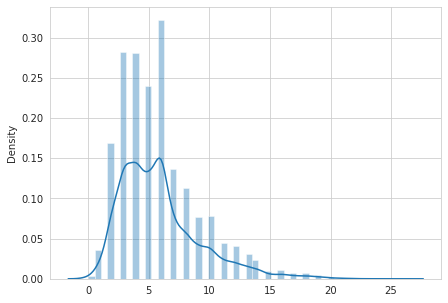

In [ ]:
size_of_sequences = [len(x.split()) for x in df["cleaned_short_desc"]]

percentile90 = round(np.percentile(a=size_of_sequences, q=90),2)
percentile95 = round(np.percentile(a=size_of_sequences, q=95),2)
mean_size = round(np.mean(size_of_sequences),2) 
max_size = round(np.max(size_of_sequences),2)

print(" Max no. of tokens in short description (sequence): ",max_size)
print(" Avg. no. of tokens in short description (sequence): ",mean_size)
print(" 90% of the sequences are <=",percentile90)
print(" 95% of the sequences are <=",percentile95)
distribution_plot(size_of_sequences)

**cleaned_desc:-**

 Max no. of tokens in description (sequence):  1808
 Avg. no. of tokens in description (sequence):  21.52
 90% of the sequences are <= 39.0
 95% of the sequences are <= 69.0


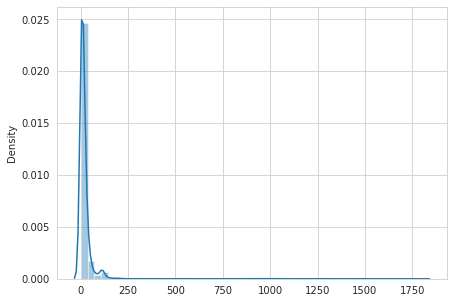

In [ ]:
size_of_sequences = [len(x.split()) for x in df["cleaned_desc"]]

percentile90 = round(np.percentile(a=size_of_sequences, q=90),2)
percentile95 = round(np.percentile(a=size_of_sequences, q=95),2)
mean_size = round(np.mean(size_of_sequences),2) 
max_size = round(np.max(size_of_sequences),2)

print(" Max no. of tokens in description (sequence): ",max_size)
print(" Avg. no. of tokens in description (sequence): ",mean_size)
print(" 90% of the sequences are <=",percentile90)
print(" 95% of the sequences are <=",percentile95)
distribution_plot(size_of_sequences)

**Wordclouds for each assignment group (target variable):**

In [ ]:
print(create_wordclouds.__doc__)


    Plots a wordcloud plot using wordcloud library. Width and height fixed at 480px and 480px respectively. 
    This plot Will display top 50 words from the text
    
    f: text as an array/list/series
    x: group label
    


In [ ]:
df["combined_tokens"] = df["cleaned_desc"] +" "+ df["cleaned_short_desc"]
for gr in df['Assignment group'].value_counts().to_dict().keys():
  assign_grp_desc = df[df['Assignment group'] == gr]["combined_tokens"]
  create_wordclouds(assign_grp_desc,gr)

Output hidden; open in https://colab.research.google.com to view.

**We only want 'cleaned_short_desc', 'cleaned_desc' and 'assignment group' column. Saving it in processed_data.csv file:**

In [ ]:
# # USE THIS SAVEPATH IF RUNNING IN GOOGLE COLAB, GIVE THE PATH WHERE YOU WANT TO SAVE
# SAVEPATH = '/content/drive/MyDrive/capstone/DataFiles/'
# # *************************** --------------------------************************************
# # SAVEPATH = 'DataFiles/'

# processed_data = df[["cleaned_short_desc","cleaned_desc","Assignment group"]]
# processed_data.to_csv(SAVEPATH+"processed_data.csv",index=False)
# processed_data.head()

,cleaned_short_desc,cleaned_desc,Assignment group
0,login issue,verify user detail employee manager name check...,GRP_0
1,outlook,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant log vpn,cannot log vpn best,GRP_0
3,unable access hr tool page,unable access hr tool page,GRP_0
4,skype error,skype error,GRP_0


### Here we will end the pre-processing work and move on to the base models. The first set of base models will be the traditional Machine Learning models that we will run on BOW and Tf-Idf transformed dataset (part2a). In second approach we will move towards Deep Learning (part2b).